In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
'''
Copyright (c) 2018 Norio Tamada
Released under the MIT license
https://github.com/darecophoenixx/wordroid.sblo.jp/blob/master/lib/keras_ex/gkernel/LICENSE.md
'''

import numpy as np
from keras import initializers, constraints
from keras.engine.topology import Layer
from keras import backend as K

class GaussianKernel(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 kernel_constraint=None,
                 kernel_gamma='auto',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        kernel_gamma:
            kernel parameter
            if 'auto', use 1/(2 * d_mean**2)
            d is distance between samples and landmark
            d_mean is mean of d
        '''
        super(GaussianKernel, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)

        # for loop
        self.indx = K.arange(self.output_dim)
        
        # kernel parameter
        self.kernel_gamma= kernel_gamma

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer,
                                      constraint=self.kernel_constraint)
        super(GaussianKernel, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, self.kernel_gamma)
    
    def gauss(self, x, landmarks, gamma):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        if gamma == 'auto':
            '''
            gamma is calculated by each batch
            '''
            d = K.sqrt(d2)
            d_mean = K.mean(d)
            gamma = 1. / (2. * d_mean**2)
        return K.exp(-gamma * d2)


class GaussianKernel2(Layer):
    
    def __init__(self, landmarks, **kwargs):
        '''
        landmarks:
            fixed landmarks using
        '''
        super(GaussianKernel2, self).__init__(**kwargs)
        self.landmarks = landmarks.astype(np.float32)
        self.num_landmark, self.num_feature = landmarks.shape
        self.output_dim = self.num_landmark
        
        # for loop
        self.indx = K.arange(self.output_dim)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel2, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.landmarks, K.exp(self.gamma_elm), training=training)
    
    def gauss(self, x, landmarks, gamma, training=None):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        
        return K.exp(-gamma * d2)


class GaussianKernel3(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        '''
        super(GaussianKernel3, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
        
        # for loop
        self.indx = K.arange(self.output_dim)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer)
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel3, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, K.exp(self.gamma_elm))
    
    def gauss(self, x, landmarks, gamma):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        
        return K.exp(-gamma * d2)


In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Colormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
n_samples = 4000

centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
X, y = datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.4, random_state=0)
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = y

df.head()

,col1,col2,cls
0,0.975303,0.821265,0
1,-1.682553,0.935898,3
2,-0.816463,1.242764,3
3,0.827815,1.459752,0
4,-1.250782,1.363415,3


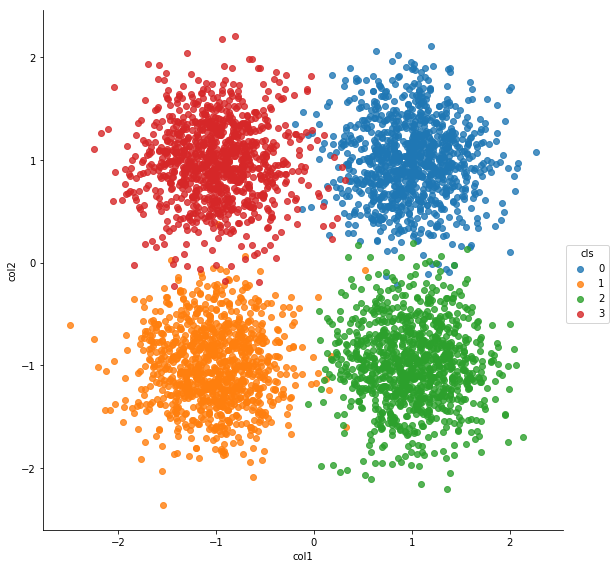

In [5]:
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

translate
* (0, 1) -> 0  
* (2, 3) -> 1

In [6]:
y2 = y.copy()
y2[np.in1d(y, (0,1))] = 0
y2[np.in1d(y, (2,3))] = 1

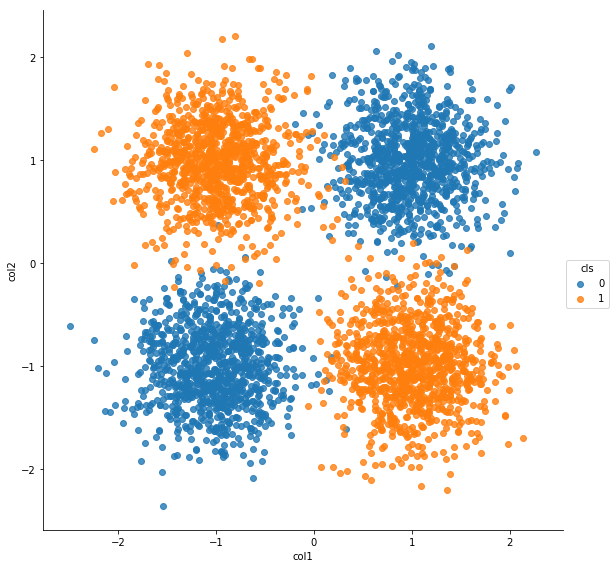

In [7]:
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = y2

sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

In [8]:
num_landmark = 15

In [9]:
np.random.seed(18237)
init_lm = np.c_[np.random.random((num_landmark,)) * 4 - 2, np.random.random((num_landmark,)) * 4 - 2]
init_lm

array([[ 0.60560739, -1.06068899],
       [-1.41575788, -0.64266191],
       [-0.04368344, -1.68674574],
       [ 0.95225195,  1.3964282 ],
       [-1.49166193,  1.96888336],
       [-1.4460619 , -0.1937981 ],
       [-1.70727843,  1.81890945],
       [-1.2955317 , -1.88197659],
       [ 1.55155814,  0.71738246],
       [ 1.22513649,  1.50135876],
       [-1.83555938,  0.65780553],
       [-1.51271109,  0.64943448],
       [ 0.08254459,  1.15797453],
       [-0.04246333,  0.61687989],
       [ 0.46991994,  0.35272227]])

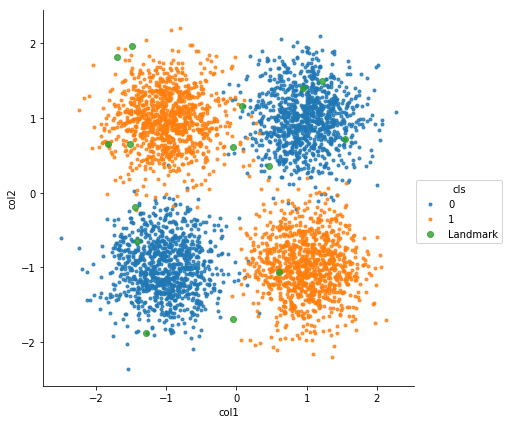

In [10]:
wgt = init_lm
df = pd.DataFrame(np.vstack([X, wgt]))
df.columns = ["col1", "col2"]
df['cls'] = [str(ee) for ee in y2] + ['Landmark']*wgt.shape[0]
sns.lmplot("col1", "col2", markers=['.', '.', 'o'], hue="cls", data=df, fit_reg=False, size=6)

In [11]:
def make_modelz():
    inp = Input(shape=(2,), name='inp')
    oup = inp
    
    weights = [init_lm, np.log(np.array([10*1/(2*2*0.1)]))]
    oup = GaussianKernel3(num_landmark, 2, weights=weights, name='gkernel1', trainable=True)(oup)
    oup = Dense(1, activation='sigmoid', name='classifier')(oup)
    model = Model(inp, oup)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return {
        'model': model,
    }

models = make_modelz()
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 2)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 15)                31        
_________________________________________________________________
classifier (Dense)           (None, 1)                 16        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [12]:
# def make_modelz():
#     inp = Input(shape=(2,), name='inp')
#     oup = inp
    
#     weights = [np.log(np.array([10*1/(2*2*0.1)])),]
#     oup = GaussianKernel2(init_lm, weights=weights, name='gkernel1', trainable=True)(oup)
#     oup = Dense(1, activation='sigmoid', name='classifier')(oup)
#     model = Model(inp, oup)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return {
#         'model': model,
#     }

# models = make_modelz()
# model = models['model']
# model.summary()

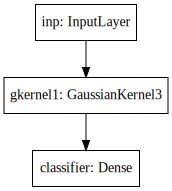

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
import keras

class SaveImage(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        x_min, x_max = (-3, 3)
        y_min, y_max = (-3, 3)
        h = .01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        y_pred = self.model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=1024)
        #print(y_pred[0])
        cm = plt.cm.coolwarm
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        y_pred = y_pred.reshape(xx.shape)
        plt.figure(figsize=(8, 6))
        plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
        wgt = model.get_layer('gkernel1').get_weights()[0]
        plt.scatter(wgt[:,0], wgt[:,1], marker='s', s=50, color='yellow', edgecolors='w')
        plt.savefig('img/img_{:0=3d}.png'.format(epoch))
        plt.close()
        #self.losses.append(logs.get('loss'))

In [15]:
save_img = SaveImage()
#callbacks=[save_img]

model.fit(X, y2, verbose=0,
          batch_size=32,
          epochs=150,
          callbacks=[save_img])

/home/admin/miniconda3/envs/snowflakes/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


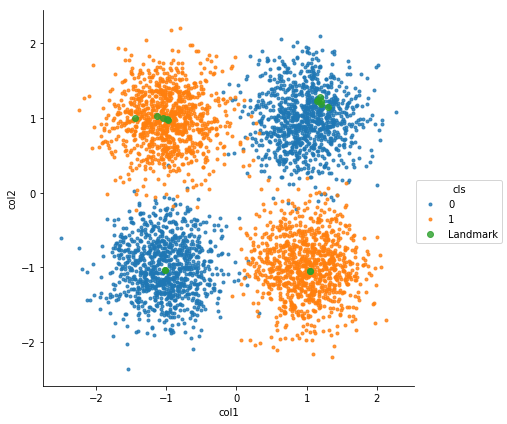

In [16]:
wgt = model.get_layer('gkernel1').get_weights()[0]
df = pd.DataFrame(np.vstack([X, wgt]))
df.columns = ["col1", "col2"]
df['cls'] = [str(ee) for ee in y2] + ['Landmark']*wgt.shape[0]
sns.lmplot("col1", "col2", markers=['.', '.', 'o'], hue="cls", data=df, fit_reg=False, size=6)

In [17]:
y_pred = model.predict(X)

In [18]:
df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = (0.5<y_pred[:,0]).astype(int)
df.head()

,col1,col2,cls
0,0.975303,0.821265,0
1,-1.682553,0.935898,1
2,-0.816463,1.242764,1
3,0.827815,1.459752,0
4,-1.250782,1.363415,1


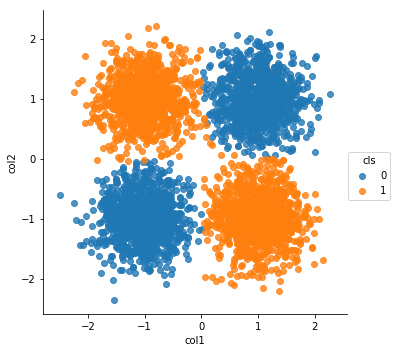

In [19]:
sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False)

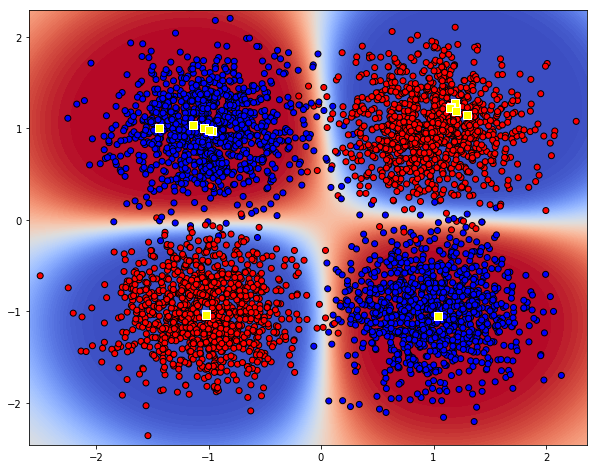

In [20]:
h = .01
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=1024)

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
y_pred = y_pred.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(X[:,0], X[:,1], c=y2, cmap=cm_bright, edgecolors='k')
plt.scatter(wgt[:,0], wgt[:,1], marker='s', s=50, color='yellow', edgecolors='w')